In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import TensorBoard, ProgbarLogger
import joblib
import nlpaug.augmenter.word as naw
import os
from tqdm import tqdm
from keras_tuner.tuners import RandomSearch


In [2]:
tweet = pd.read_csv("Tweets.csv")
tweet

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [3]:
tweet = tweet.drop(columns=['textID', "text"], axis=1)
tweet.shape


(27481, 2)

In [4]:
tweet = tweet.dropna()
tweet.shape


(27480, 2)

In [5]:
tweet = tweet.loc[(tweet['sentiment'] == 'positive') | (tweet['sentiment'] == 'negative')]
tweet

,selected_text,sentiment
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative
6,fun,positive
...,...,...
27475,enjoy,positive
27476,d lost,negative
27477,", don`t force",negative
27478,Yay good for both of you.,positive


In [6]:
tweet.replace({'sentiment': {'negative': 0, 'positive': 1}}, inplace=True)
tweet

,selected_text,sentiment
1,Sooo SAD,0
2,bullying me,0
3,leave me alone,0
4,"Sons of ****,",0
6,fun,1
...,...,...
27475,enjoy,1
27476,d lost,0
27477,", don`t force",0
27478,Yay good for both of you.,1


In [7]:
tweet['selected_text'] = tweet['selected_text'].str.lower()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Initialize augmenters
syn_aug = naw.SynonymAug(aug_src='wordnet')
del_aug = naw.RandomWordAug(action="delete")
swap_aug = naw.RandomWordAug(action="swap")

augmented_dfs = []

# Reduce the number of augmentations to save memory
print("Augmenting data...")
for i in tqdm(range(int(tweet.shape[0] * 0.1))):  # Only augment 10% of the data
    original_text = tweet['selected_text'].iloc[i]
    # Apply different augmentations
    augmented_texts = [syn_aug.augment(original_text), del_aug.augment(original_text)]
    for augmented_text in augmented_texts:
        augmented_df = pd.DataFrame({'selected_text': [augmented_text], 'sentiment': tweet['sentiment'].iloc[i]})
        augmented_dfs.append(augmented_df)

# Concatenate the original DataFrame with the augmented dataframes
tweet = pd.concat([tweet] + augmented_dfs, ignore_index=True)
print(tweet)
joblib.dump(tweet, 'preprocessed_augmented_tweet.pkl')


Augmenting data...


100%|██████████| 1636/1636 [00:01<00:00, 822.07it/s] 


        selected_text  sentiment
0            sooo sad          0
1         bullying me          0
2      leave me alone          0
3       sons of ****,          0
4                 fun          1
...               ...        ...
19630            [..]          0
19631    [thank you!]          1
19632        [thank!]          1
19633          [sap!]          0
19634             [!]          0

[19635 rows x 2 columns]


['preprocessed_augmented_tweet.pkl']

In [9]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from tqdm import tqdm
import joblib
import nltk

# Step 2: Load preprocessed and augmented data
tweet = joblib.load('preprocessed_augmented_tweet.pkl')

# Download stopwords if not already available
nltk.download('stopwords')

# Define regex for cleaning text
text_cleaning_regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# Define stop words
stop_words = set(nltk.corpus.stopwords.words('english'))

# Define function to clean tweets
def clean_tweets(text, stem=False):
    text = re.sub(text_cleaning_regex, ' ', str(text).lower()).strip()
    tokens = [token for token in text.split() if token not in stop_words]
    return " ".join(tokens)

# Apply cleaning function to the DataFrame
print("Cleaning tweets...")
tweet['selected_text'] = tweet['selected_text'].apply(lambda x: clean_tweets(x))

# Extract TF-IDF features
print("Extracting TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Reduce max features to save memory
tfidf_features = tfidf_vectorizer.fit_transform(tweet['selected_text']).toarray()

# Save the TfidfVectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("TfidfVectorizer saved as 'tfidf_vectorizer.pkl'")

# Extract Sentiment features using VADER
analyzer = SentimentIntensityAnalyzer()
def extract_sentiment_features(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return [sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['pos'], sentiment_scores['compound']]

print("Extracting sentiment features...")
sentiment_features = np.array([extract_sentiment_features(text) for text in tqdm(tweet['selected_text'])])

# Combine features into a single DataFrame
combined_features = np.hstack([tfidf_features, sentiment_features])

# Save features and labels
joblib.dump((combined_features, tweet['sentiment']), 'features_labels.pkl')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning tweets...
Extracting TF-IDF features...
TfidfVectorizer saved as 'tfidf_vectorizer.pkl'
Extracting sentiment features...


100%|██████████| 19635/19635 [00:00<00:00, 86819.96it/s]


['features_labels.pkl']

In [10]:
import joblib
from sklearn.model_selection import train_test_split

# Step 3: Load features and labels
combined_features, sentiment = joblib.load('features_labels.pkl')

# Split the data into train and test sets
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(combined_features, sentiment, test_size=0.2, random_state=16)

print("Train Data size:", len(X_train))
print("Test Data size:", len(X_test))

# Save the split data
joblib.dump((X_train, X_test, y_train, y_test), 'split_data.pkl')


Splitting data into train and test sets...
Train Data size: 15708
Test Data size: 3927


['split_data.pkl']

In [11]:
import joblib
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV

# Step 4: Load split data
X_train, X_test, y_train, y_test = joblib.load('split_data.pkl')

# Define base models for stacking
base_models = [
    ('lr', LogisticRegression(solver='liblinear', max_iter=1000)),
    ('rf', RandomForestClassifier())
]

# Define the stacking ensemble model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# Define parameter grid for GridSearch
param_grid = {
    'lr__C': [0.1, 1.0, 10.0],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20]
}

# Perform Grid Search with Cross Validation
print("Performing Grid Search...")
grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model after Grid Search
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Save the best model
model_filename = 'trained_stacking_model.pkl'
joblib.dump(best_model, model_filename)

# Verify if the file exists
if os.path.exists(model_filename):
    print(f"File '{model_filename}' saved successfully!")
else:
    print(f"Error in saving the model '{model_filename}'!")


Performing Grid Search...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters found:  {'lr__C': 10.0, 'rf__max_depth': None, 'rf__n_estimators': 100}
File 'trained_stacking_model.pkl' saved successfully!


Evaluating the model...
Test Loss: 0.884899
Test Accuracy: 0.884899
Accuracy Score: 0.8849
F1 Score: 0.8845
ROC AUC Score: 0.9560
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      1879
           1       0.93      0.84      0.88      2048

    accuracy                           0.88      3927
   macro avg       0.89      0.89      0.88      3927
weighted avg       0.89      0.88      0.88      3927



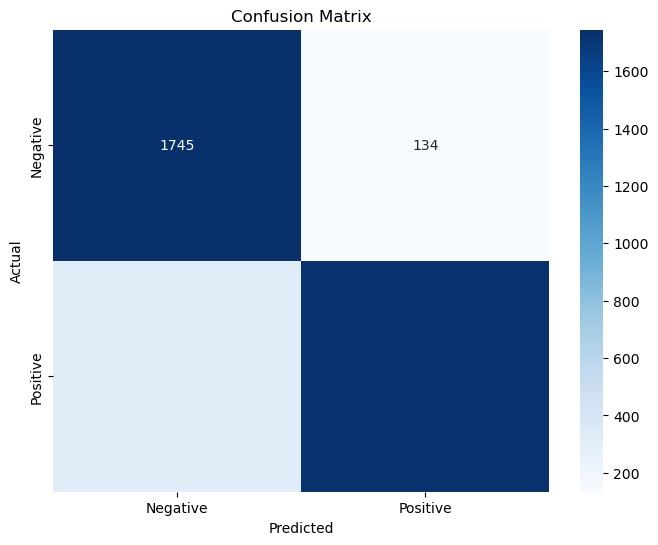

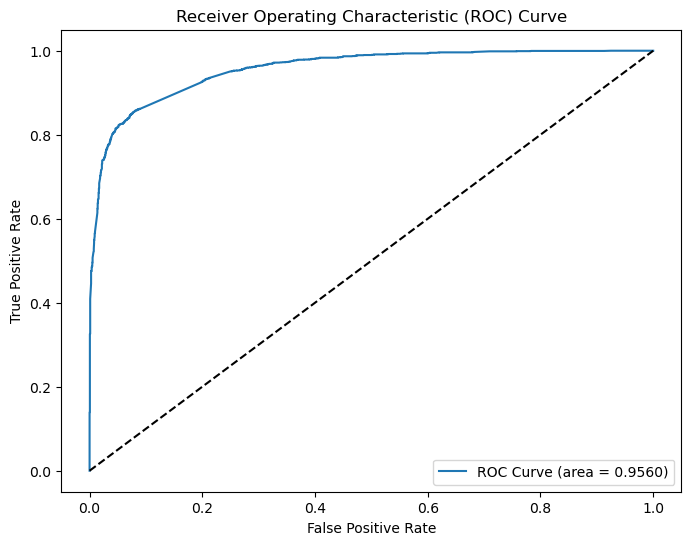

In [12]:

# Step 5: Load best model and split data
model_filename = 'trained_stacking_model.pkl'
best_model = joblib.load(model_filename)

# Evaluate the model
print("Evaluating the model...")
test_loss = best_model.score(X_test, y_test)
test_accuracy = accuracy_score(y_test, best_model.predict(X_test))

print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.6f}".format(test_accuracy))

# Predictions
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate different evaluation metrics
print("Accuracy Score: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
print("ROC AUC Score: {:.4f}".format(roc_auc_score(y_test, y_pred_prob)))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.4f})'.format(roc_auc_score(y_test, y_pred_prob)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

import os



In [2]:

# Step 6: Verify if the file exists before loading
model_filename = 'trained_stacking_model.pkl'
if os.path.exists(model_filename):
    print(f"File '{model_filename}' exists. Proceeding to load the model.")
else:
    print(f"File '{model_filename}' does not exist. Cannot load the model.")
    raise FileNotFoundError(f"File '{model_filename}' not found.")

# Load the model
best_model = joblib.load(model_filename)

# Load other necessary objects
tfidf_vectorizer_filename = 'tfidf_vectorizer.pkl'
if os.path.exists(tfidf_vectorizer_filename):
    print(f"File '{tfidf_vectorizer_filename}' exists. Proceeding to load the TfidfVectorizer.")
else:
    print(f"File '{tfidf_vectorizer_filename}' does not exist. Cannot load the TfidfVectorizer.")
    raise FileNotFoundError(f"File '{tfidf_vectorizer_filename}' not found.")

tfidf_vectorizer = joblib.load(tfidf_vectorizer_filename)
sentiment_analyzer = SentimentIntensityAnalyzer()

def extract_sentiment_features(text):
    sentiment_scores = sentiment_analyzer.polarity_scores(text)
    return [sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['pos'], sentiment_scores['compound']]

def predict_sentiment(model, phrase, bound=0.9):
    tfidf_phrase = tfidf_vectorizer.transform([phrase]).toarray()
    sentiment_phrase = np.array([extract_sentiment_features(phrase)])
    combined_phrase_features = np.hstack([tfidf_phrase, sentiment_phrase])

    # Use predict_proba to get the probability scores
    prediction_prob = model.predict_proba(combined_phrase_features)
    prediction = model.predict(combined_phrase_features)

    sentiment_label = 'neutral'
    if prediction[0] == 1 and prediction_prob[0][1] >= bound:
        sentiment_label = 'positive'
    elif prediction[0] == 0 and prediction_prob[0][0] >= bound:
        sentiment_label = 'negative'

    return sentiment_label, prediction_prob

phrase_to_predict = "glasses"
label, score = predict_sentiment(best_model, phrase_to_predict)

print(f"Phrase: {phrase_to_predict}")
print(f"Predicted Sentiment: {label}")
print(f"Confidence Score: {score[0][1] if label == 'positive' else score[0][0]}")


NameError: name 'os' is not defined